In [1]:
import os
!pip install opencv-python
import cv2
import numpy as np

from matplotlib import pyplot as plt
# !pip install patchify
# from patchify import patchify
from PIL import Image
os.environ["SM_FRAMEWORK"] = "tf.keras"
!pip install segmentation-models
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from keras.layers import Flatten
from tensorflow.keras.backend import sum
from keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import time
from IPython.display import display, clear_output
from IPython.display import Image as ig
from keras.callbacks import EarlyStopping, ModelCheckpoint

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


2024-04-07 21:32:32.576984: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 21:32:32.577099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 21:32:32.741344: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


In [2]:
scaler=MinMaxScaler()

In [3]:
root_dir='/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/'
patch_size=256

In [4]:
image_dataset=[]
img_dt=[]
msk_dt=[]
mask_dataset=[]
cnt=0
cnt1=0

df=pd.read_csv('/kaggle/input/augmented-forest-segmentation/meta_data.csv')
df=df[0:3500]
img_path=[]
msk_path=[]
for i in range(len(df)):
	img_path.append(root_dir+'images/'+df['image'][i])
	msk_path.append(root_dir+'masks/'+df['mask'][i])
print(img_path[0:5])
print(msk_path[0:5])
# df.head()
print(len(df))
for i in tqdm(range(len(df))):
	image=cv2.imread(img_path[i],1)
	image = Image.fromarray(image)
	image = np.array(image)  
	img_dt.append(image)
	mask=cv2.imread(msk_path[i],0)
	mask = Image.fromarray(mask)
	mask = np.array(mask)
	msk_dt.append(mask)

img_dt = np.reshape(img_dt, (len(df), patch_size, patch_size, 3))
for i in tqdm(range(len(df))):
	img=img_dt[i]
	scld_img=scaler.fit_transform(img.reshape(-1,img.shape[-1])).reshape(img.shape)
	image_dataset.append(scld_img)
image_dataset=np.array(image_dataset)

msk_dt = np.reshape(msk_dt, (len(df), patch_size, patch_size, 1))
for i in tqdm(range(len(df))):
	msk=msk_dt[i]
	mask_dataset.append(msk)
mask_dataset=np.array(mask_dataset)

print(image_dataset.shape)
print(mask_dataset.shape)

['/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/10452_sat_08.jpg', '/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/10452_sat_18.jpg', '/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/111335_sat_00.jpg', '/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/111335_sat_01.jpg', '/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/111335_sat_02.jpg']
['/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/10452_mask_08.jpg', '/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/10452_mask_18.jpg', '/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/111335_mask_00.jpg', '/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/111335_mask_01.jpg', '/kaggle/input/augmented-forest-segmentation/For

100%|██████████| 3500/3500 [00:00<00:00, 880574.89it/s]

(3500, 256, 256, 3)
(3500, 256, 256, 1)


756


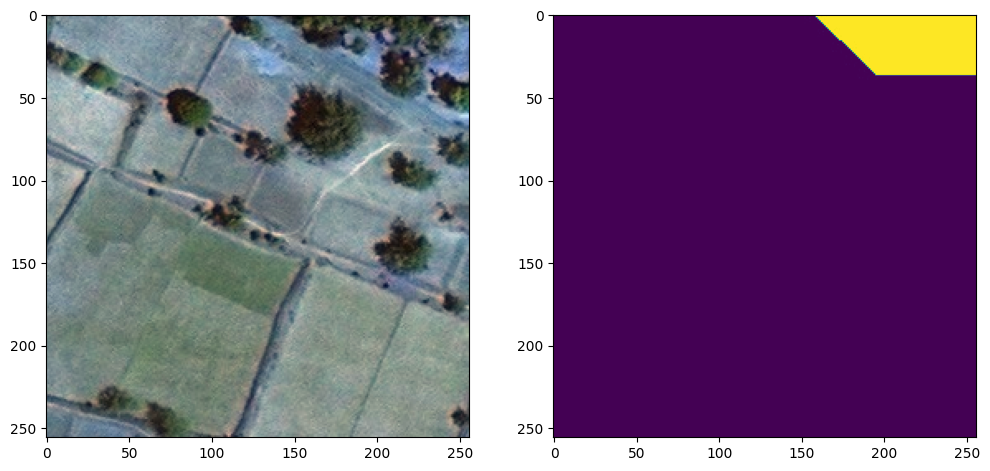

In [5]:
import gc
del img_dt, msk_dt,scld_img
gc.collect()
#Sanity check, view few mages
image_number = random.randint(0, len(image_dataset))
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 1)))
plt.show()

In [6]:
print(mask_dataset[0])

[[[  0]
  [  0]
  [  0]
  ...
  [255]
  [255]
  [255]]

 [[  0]
  [  0]
  [  0]
  ...
  [255]
  [255]
  [255]]

 [[  0]
  [  0]
  [  0]
  ...
  [255]
  [255]
  [255]]

 ...

 [[  0]
  [  0]
  [  0]
  ...
  [255]
  [255]
  [255]]

 [[  0]
  [  0]
  [  0]
  ...
  [255]
  [255]
  [255]]

 [[  0]
  [  0]
  [  0]
  ...
  [255]
  [255]
  [255]]]


In [7]:
# labels=np.zeros(mask_dataset.shape,dtype=np.uint8)
# labels[np.all(mask_dataset == [0],axis=-1)] = 0
print(np.unique(mask_dataset))
mask_dataset[np.all(mask_dataset == [0],axis=-1)] = 0
mask_dataset[np.all(mask_dataset == [1],axis=-1)] = 0
mask_dataset[np.all(mask_dataset == [2],axis=-1)] = 0
mask_dataset[np.all(mask_dataset == [3],axis=-1)] = 0
mask_dataset[np.all(mask_dataset == [4],axis=-1)] = 0
mask_dataset[np.all(mask_dataset == [5],axis=-1)] = 0
mask_dataset[np.all(mask_dataset == [6],axis=-1)] = 0
mask_dataset[np.all(mask_dataset == [7],axis=-1)] = 0
mask_dataset[np.all(mask_dataset == [8],axis=-1)] = 0
mask_dataset[np.all(mask_dataset == [9],axis=-1)] = 0
mask_dataset[np.all(mask_dataset == [246],axis=-1)] = 1
mask_dataset[np.all(mask_dataset == [247],axis=-1)] = 1
mask_dataset[np.all(mask_dataset == [248],axis=-1)] = 1
mask_dataset[np.all(mask_dataset == [249],axis=-1)] = 1
mask_dataset[np.all(mask_dataset == [250],axis=-1)] = 1
mask_dataset[np.all(mask_dataset == [251],axis=-1)] = 1
mask_dataset[np.all(mask_dataset == [252],axis=-1)] = 1
mask_dataset[np.all(mask_dataset == [253],axis=-1)] = 1
mask_dataset[np.all(mask_dataset == [254],axis=-1)] = 1
mask_dataset[np.all(mask_dataset == [255],axis=-1)] = 1
print(np.unique(mask_dataset))


[  0   1   2   3   4   5   6   7   8   9 246 247 248 249 250 251 252 253
 254 255]
[0 1]


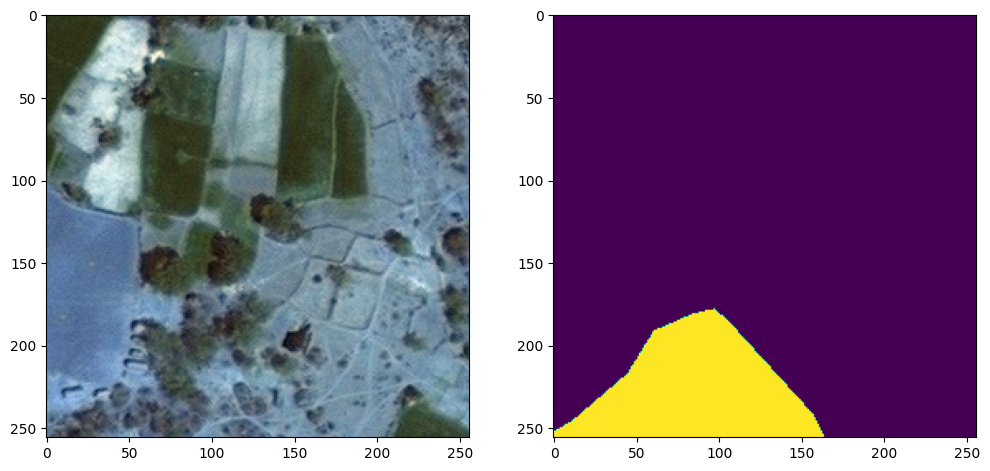

In [8]:
#Another Sanity check, view few images
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 1)))
plt.show()

In [9]:
# import gc
# del img_dt, msk_dt
# gc.collect()
n_classes = len(np.unique(mask_dataset))
from keras.utils import to_categorical
print(np.unique(mask_dataset))
labels_cat = to_categorical(mask_dataset, num_classes=n_classes)
print(labels_cat[0:1])
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)
# Split data into train and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.42, random_state=42)

# Further split the training data into train and validation (e.g., 80% train, 20% validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42)
print(len(X_train),' ',len(X_val),' ',len(X_test))

[0 1]
[[[[1. 0.]
   [1. 0.]
   [1. 0.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[1. 0.]
   [1. 0.]
   [1. 0.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[1. 0.]
   [1. 0.]
   [1. 0.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  ...

  [[1. 0.]
   [1. 0.]
   [1. 0.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[1. 0.]
   [1. 0.]
   [1. 0.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]

  [[1. 0.]
   [1. 0.]
   [1. 0.]
   ...
   [0. 1.]
   [0. 1.]
   [0. 1.]]]]
2030   486   984


In [10]:
gc.collect()

12883

In [11]:
def jacard_coef(y_true, y_pred):
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (sum(y_true_f) + sum(y_pred_f) - intersection + 1.0)


In [12]:
reg = regularizers.l1_l2(l2=0.01)

def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=reg)(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [13]:
np.unique(y_test)
y_train.shape

(2030, 256, 256, 2)

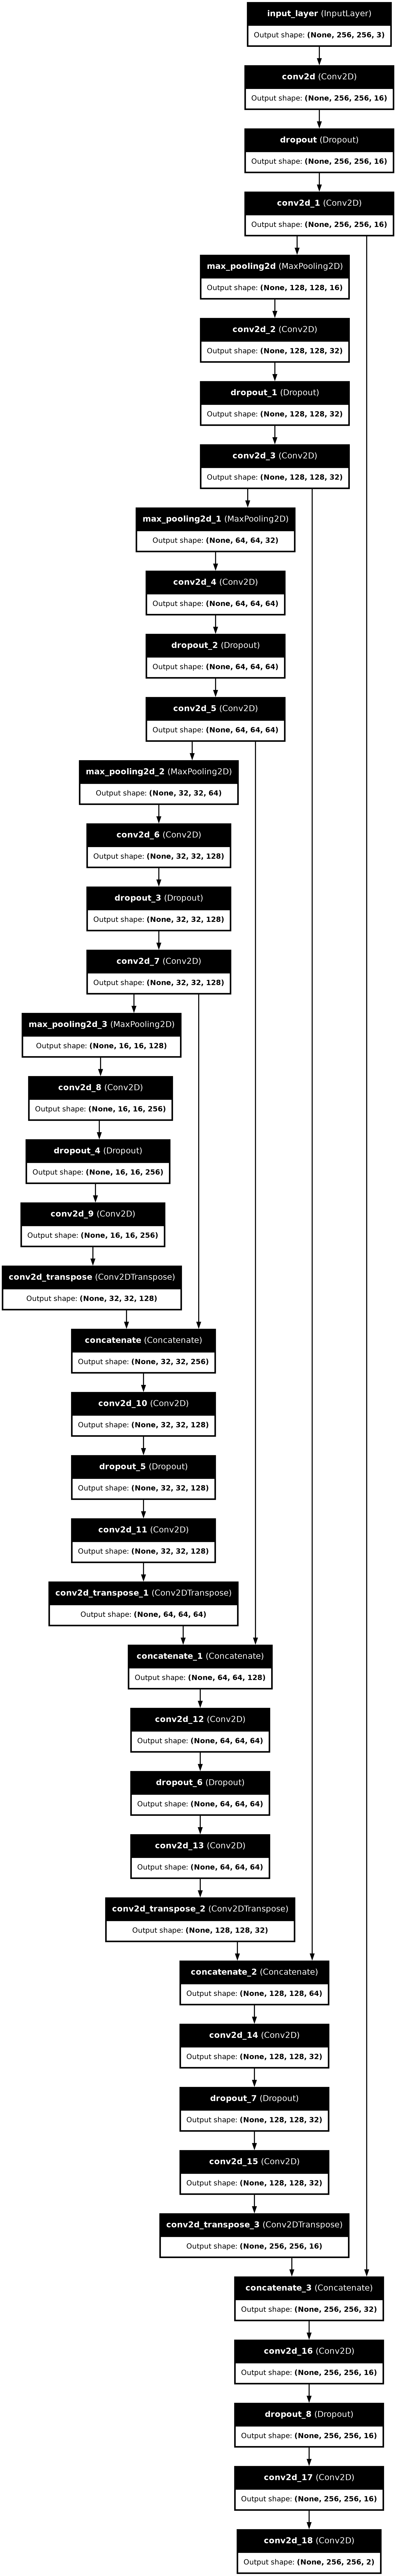

In [14]:
weights = [0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #
learning_rate = 0.0005

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


metrics=['accuracy', jacard_coef]
optimizer = optimizers.Adam(learning_rate=learning_rate)
data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

# Create the ImageDataGenerator object
image_datagen = ImageDataGenerator(**data_gen_args)
# Fit the generator to your data
image_datagen.fit(X_train)

model = multi_unet_model(n_classes=2, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
#model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
# model.summary()
plot_model(model, to_file='/kaggle/working/unet_model.png', show_shapes=True, show_layer_names=True)
ig(filename='/kaggle/working/unet_model.png') 

In [15]:
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, filepath, monitor='val_loss', save_best_only=True, mode='max', verbose=1):
        super().__init__(filepath, monitor=monitor, save_best_only=save_best_only, mode=mode, verbose=verbose)

    def on_epoch_end(self, epoch, logs=None):
        # Modify the filepath to include the epoch number
        self.filepath = f"/kaggle/working/epoch_{epoch + 1}.keras"
        super().on_epoch_end(epoch, logs)

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = CustomModelCheckpoint("/kaggle/working/model_weights.keras", monitor='val_loss',
                             save_best_only=True, mode='min', verbose=1)
callbacks = [early_stopping,checkpoint,tf.keras.callbacks.TensorBoard(log_dir='logs')]
# history1 = model.fit(X_train, y_train, 
#                     batch_size = 16, 
#                     verbose=1, 
#                     epochs=70, 
#                     validation_data=(X_test, y_test), 
#                     shuffle=False)
batch_size=32
history1=model.fit(image_datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(X_train) / batch_size), 
                    epochs=80,
                    validation_data=(X_val, y_val) ,
                    callbacks=callbacks,
                    shuffle=False
                    )

Epoch 1/80


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1712525783.465090     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.5480 - jacard_coef: 0.3366 - loss: 23.4897
Epoch 1: val_loss improved from inf to 9.98686, saving model to /kaggle/working/epoch_1.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 112s 692ms/step - accuracy: 0.5485 - jacard_coef: 0.3366 - loss: 23.4072 - val_accuracy: 0.5977 - val_jacard_coef: 0.3382 - val_loss: 9.9869
Epoch 2/80
 1/63 ━━━━━━━━━━━━━━━━━━━━ 44:21 43s/step - accuracy: 0.4163 - jacard_coef: 0.3240 - loss: 10.0236

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 9.98686 to 9.82928, saving model to /kaggle/working/epoch_2.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.4163 - jacard_coef: 0.3240 - loss: 10.0236 - val_accuracy: 0.5977 - val_jacard_coef: 0.3383 - val_loss: 9.8293
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.6077 - jacard_coef: 0.3428 - loss: 7.9446
Epoch 3: val_loss improved from 9.82928 to 4.11496, saving model to /kaggle/working/epoch_3.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 526ms/step - accuracy: 0.6077 - jacard_coef: 0.3428 - loss: 7.9216 - val_accuracy: 0.5976 - val_jacard_coef: 0.3537 - val_loss: 4.1150
Epoch 4/80
 1/63 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.5246 - jacard_coef: 0.3407 - loss: 4.1494
Epoch 4: val_loss improved from 4.11496 to 4.06671, saving model to /kaggle/working/epoch_4.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5246 - jacard_coef: 0.3407 - loss: 4.1494 - val_accuracy: 0.5976 - val_jacard_coef: 0.3542 - val_loss: 

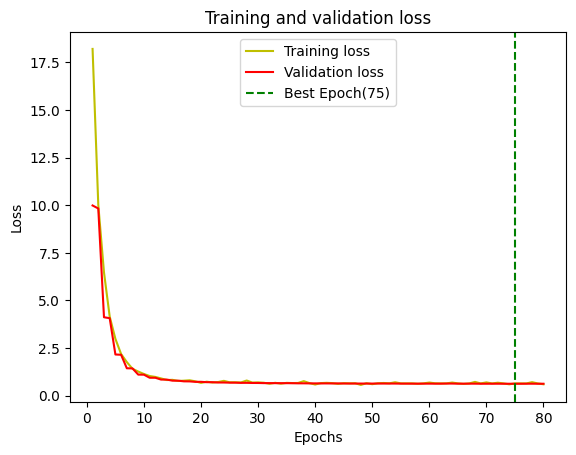

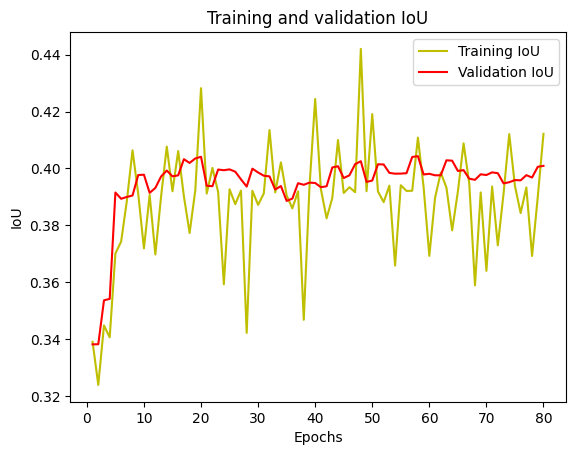

In [26]:
weight_files = [f for f in os.listdir('/kaggle/working/') if f.startswith('epoch_')]
epochs = [int(f.split('_')[1].split('.')[0]) for f in weight_files]
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']

best_epoch = max(epochs)

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
if best_epoch:
    plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Epoch({best_epoch})')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [27]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 483ms/step
Mean IoU = 0.41797203


epoch_75.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


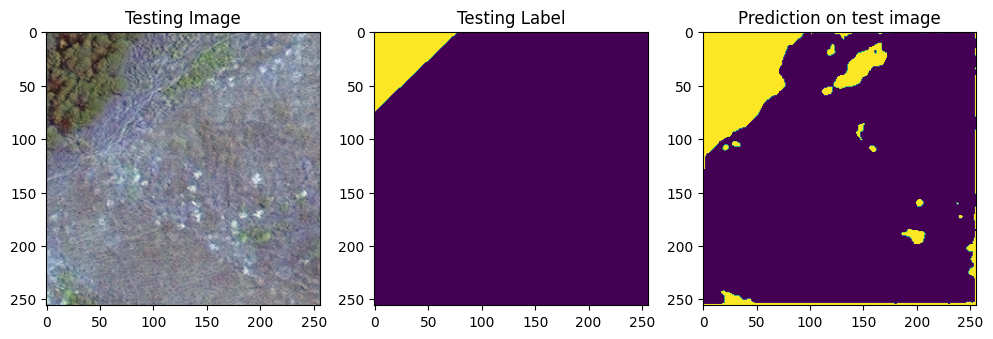

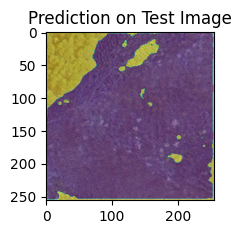

In [29]:
#Predict on a few images
# weight_files = [f for f in os.listdir('/kaggle/working/') if f.startswith('epoch_')]
latest_weight_file = max(weight_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
print(latest_weight_file)
model.load_weights(os.path.join('/kaggle/working/', latest_weight_file))
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()
plt.subplot(224)
plt.title('Prediction on Test Image')
plt.imshow(test_img, alpha=1)  # Overlay the testing image
plt.imshow(predicted_img, alpha=0.5)  # Overlay the predicted image

In [ ]:
model.save('/kaggle/working/unetmodel.h5')

In [30]:
import cv2
import numpy as np
video_path='/kaggle/input/areal-forest-vid/AF.mp4'
def convert_video_to_frames(video_path, target_size=(256, 256)):
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    frames = []
    while success:
        resized_image = cv2.resize(image, target_size)
        frames.append(resized_image)
        success, image = vidcap.read()
    return frames

In [ ]:
from tqdm import tqdm
fm=convert_video_to_frames(video_path)
fm=np.array(fm)
fm_dt=[]
for i in tqdm(range(len(fm)-600)):
	img=fm[i]
	scld_img=scaler.fit_transform(img.reshape(-1,img.shape[-1])).reshape(img.shape)
	fm_dt.append(scld_img)
fm_dt=np.array(fm_dt)

100%|██████████| 1128/1128 [00:09<00:00, 119.56it/s]


In [ ]:
predicted_masks = model.predict(fm_dt)

# Convert the predicted masks to an array
predicted_masks_array = np.argmax(predicted_masks, axis=3)
fig = plt.figure()

for i in range(0,int((len(predicted_masks_array)/2)),4):
    plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid
    plt.title('Original Image')
    plt.imshow(fm_dt[i])
    
    plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
    plt.title('Prediction on test image')
    plt.imshow(predicted_masks_array[i])
    
    display(fig)
    clear_output(wait=True)
#     time.sleep(1/30)
